<a href="https://colab.research.google.com/github/a1manz0/sentiment-topic-classifier/blob/main/notebooks/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ тональности и классификации тем

## 0. Настройка окружения

### 0.1 Клонирование репозитория

In [1]:
!git clone https://github.com/sismetanin/rureviews.git

Cloning into 'rureviews'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 14 (delta 4), reused 1 (delta 1), pack-reused 8 (from 1)
Receiving objects: 100% (14/14), 5.44 MiB | 9.88 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### 0.2 Установка библиотек

### 0.3 Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import AutoTokenizer, AutoModel

### 0.4 Настройка визуализации

In [32]:
# Устанавливаем темную тему
plt.style.use('dark_background')

# Настройка стиля Seaborn
sns.set_style("darkgrid", {
    'axes.grid': True,
    'axes.facecolor': '#1a1a1a',
    'figure.facecolor': '#1a1a1a',
    'grid.color': '#404040',
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})

In [42]:
# функция для визуализации данных
def draw_df(df, x, title='Распределение числовых меток'):
  sns.countplot(data=df, x=x)
  plt.title(title)
  plt.xticks(rotation=45)
  plt.show()

### 0.5 Проверка устройств

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Загрузка данных

### 1.1 Загрузка датасета

1. Чтение датасета
2. Проверка структуры данных
3. Базовая статистика

In [5]:
data_path = Path('/content/rureviews/women-clothing-accessories.3-class.balanced.csv')
df = pd.read_csv(data_path, sep='\t', encoding='utf-8') # пропускаем проблемные строки

In [8]:
print("Размер датасета:", df.shape)
print("\nКолонки:")
print(df.columns)
print("\nПервые строки:")
print(df.head(-20))

Размер датасета: (90000, 2)

Колонки:
Index(['review', 'sentiment'], dtype='object')

Первые строки:
                                                  review sentiment
0      качество плохое пошив ужасный (горловина напер...  negative
1      Товар отдали другому человеку, я не получила п...  negative
2      Ужасная синтетика! Тонкая, ничего общего с пре...  negative
3      товар не пришел, продавец продлил защиту без м...  negative
4          Кофточка голая синтетика, носить не возможно.  negative
...                                                  ...       ...
89975  Штанишки классные,все по размеру,хорошего каче...  positive
89976  Качество очень хорошее, н/б соответствует карт...  positive
89977  Хорошая шапочка, качество  Доча очень довольна...  positive
89978                 Хорошая юбка, в отличном состоянии  positive
89979  До Крыма заказ шёл чуть меньше двух недель;на ...  positive

[89980 rows x 2 columns]


##2 Анализ и очистка меток

Задачи:
1. Увидеть все возможные значения тональности
2. Понять распределение классов
3. Проверить, нет ли опечаток или неправильных значений
4. Определить, нужна ли балансировка классов

После этого мы сможем:
1. Создать маппинг тональности в числовые метки
2. Проверить пропущенные значения
3. Начать предобработку текста

### 2.1 Проверка уникальных значений

In [9]:
print("Уникальные значения в колонке sentiment:")
print(df['sentiment'].unique())

Уникальные значения в колонке sentiment:
['negative' 'neautral' 'positive']


In [10]:
print("\nРаспределение значений sentiment:")
print(df['sentiment'].value_counts())


Распределение значений sentiment:
sentiment
negative    30000
neautral    30000
positive    30000
Name: count, dtype: int64


### 2.2 Проверяем пропущенные данные

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


### 2.3 Исправление опечаток

Распределение до очистки:
sentiment
negative    30000
neautral    30000
positive    30000
Name: count, dtype: int64


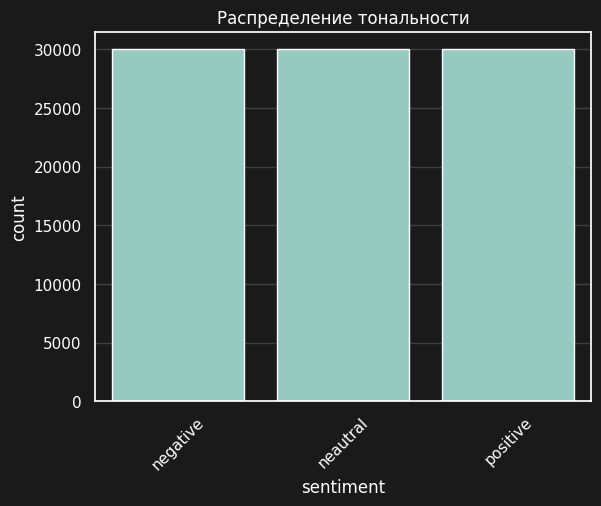


Распределение после очистки:
sentiment_cleaned
negative    30000
neutral     30000
positive    30000
Name: count, dtype: int64


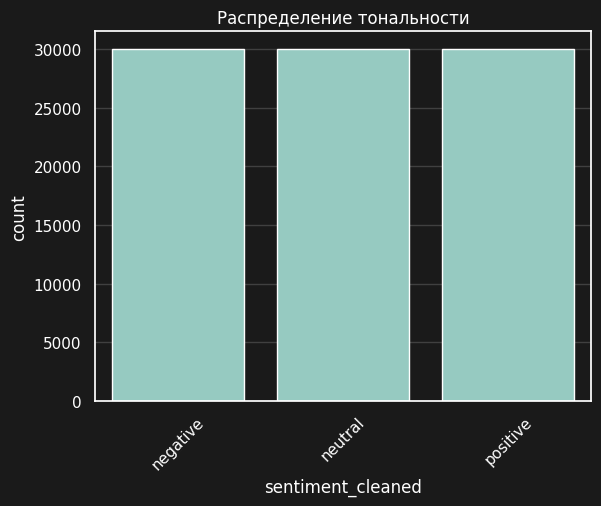

In [39]:
# Создаем функцию для исправления значений
def clean_sentiment(value):
    if pd.isna(value):  # проверяем на NaN
        return 'unknown'

    # Приводим к нижнему регистру
    value = str(value).lower().strip()

    # Исправляем опечатки и сокращения
    if value in ['positive', 'pos', 'positiv', 'postive']:
        return 'positive'
    elif value in ['negative', 'neg', 'negativ', 'negatve']:
        return 'negative'
    elif value in ['neautral', 'neutral', 'neutr', 'neut']:
        return 'neutral'
    else:
        return 'unknown'

# Применяем очистку
df['sentiment_cleaned'] = df['sentiment'].apply(clean_sentiment)

# визуализация до очистки
print("Распределение до очистки:")
print(df['sentiment'].value_counts())
draw_df(df, 'sentiment')

# визуализация после очистки
print("\nРаспределение после очистки:")
print(df['sentiment_cleaned'].value_counts())
draw_df(df, 'sentiment_cleaned')

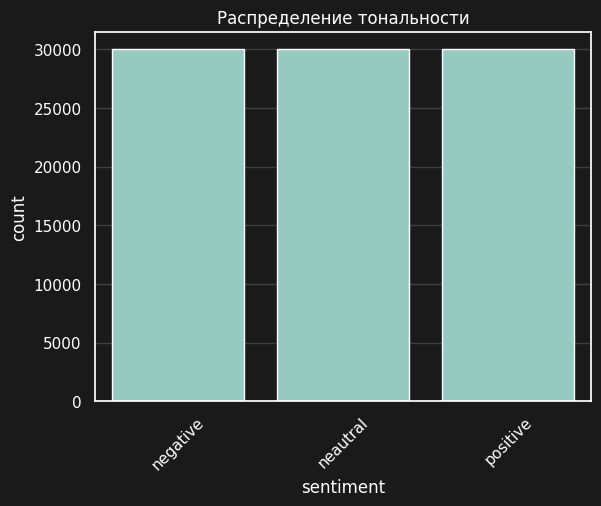

In [36]:
draw_df(df, 'sentiment')

## 3 Балансировка классов (если необходима)

In [18]:
from sklearn.utils import resample

Распределение классов после балансировки:
sentiment
positive    20000
negative    20000
neautral    20000
Name: count, dtype: int64


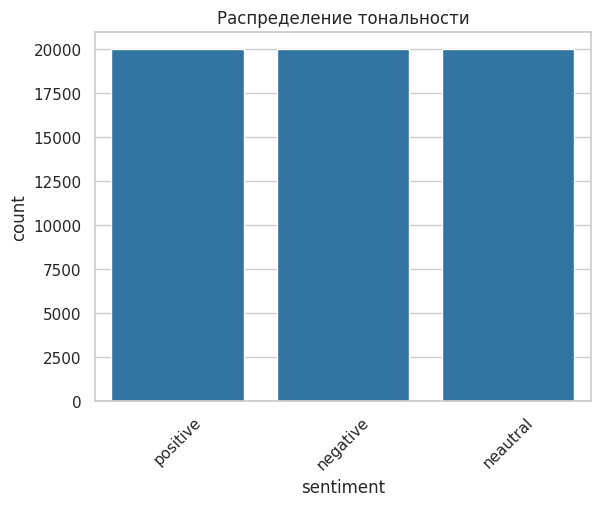

In [26]:
n_samples = 20000

df_positive = df[df.sentiment == 'positive']
df_negative = df[df.sentiment == 'negative']
df_neutral = df[df.sentiment == 'neautral']


df_positive_downsampled = resample(
    df_positive,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

df_negative_balanced = resample(
    df_negative,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

df_neutral_balanced = resample(
    df_neutral,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

# Объединяем сбалансированные данные
df_balanced = pd.concat([
    df_positive_downsampled,
    df_negative_balanced,
    df_neutral_balanced
])

# Перемешиваем данные
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем результат
print("Распределение классов после балансировки:")
print(df_balanced['sentiment'].value_counts())

# Визуализируем результат
draw_df(df_balanced)

## 4. Преобразование меток

In [16]:
def convert_sentiment_to_number(sentiment):
  if sentiment == "negative":
    return

Пример преобразования:
  sentiment_cleaned  sentiment_id
0          negative             0
1          negative             0
2          negative             0
3          negative             0
4          negative             0
5          negative             0
6          negative             0
7          negative             0
8          negative             0
9          negative             0


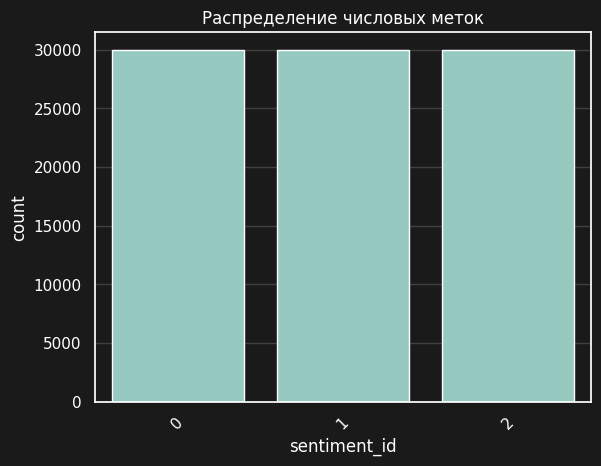

In [43]:
# Создаем маппинги для sentiment
sentiment_to_id = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Создаем числовые метки
df['sentiment_id'] = df['sentiment_cleaned'].map(sentiment_to_id)

# Проверяем результат
print("Пример преобразования:")
print(df[['sentiment_cleaned', 'sentiment_id']].head(10))

# Визуализируем распределение числовых меток
draw_df(df, x='sentiment_id', title='Распределение числовых меток')

### 5. Предобработка текста

In [47]:
df['text_cleaned'] = df['review'].apply(lambda x: x.lower().strip())

In [48]:
df['text_cleaned'].head()

,text_cleaned
0,качество плохое пошив ужасный (горловина напер...
1,"товар отдали другому человеку, я не получила п..."
2,"ужасная синтетика! тонкая, ничего общего с пре..."
3,"товар не пришел, продавец продлил защиту без м..."
4,"кофточка голая синтетика, носить не возможно."


## 6. Подготовка для модели

### 6.1 Инициализация токенизатора

In [49]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### 6.2 Создание датасета

In [50]:
from sklearn.model_selection import train_test_split

# Разделение на train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)